# Time Series Analysis

### Predicting Berlin Mitte weather using autogression models

In [153]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)

In [154]:
# skiprows to rid header
df = pd.read_csv('TG_STAID004563.txt', skiprows = 19)

In [155]:
# lots of whitespace in column names
df.rename(columns=lambda x: x.strip(), inplace=True)

In [156]:
df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y%m%d')
df.set_index(df['DATE'], inplace=True)

In [157]:
# using only part of data - also 1945 has lots of missing/-9999 values that interfere
mask = (df.index >= '2016-01-01') & (df.index <= '2019-12-31')
df = df.loc[mask]

In [158]:
# negative temperature values ~~ log transformations, so converting temp to kelvin
df['TG'] = df['TG'].apply(lambda x: x * 0.1 + 273.15) 

In [159]:
df.drop('SOUID', axis=1, inplace=True)

In [160]:
df.drop('DATE', axis=1, inplace=True)

In [161]:
df.drop('Q_TG', axis=1, inplace=True)

In [162]:
df.head()

,TG
DATE,
2016-01-01,274.85
2016-01-02,269.45
2016-01-03,263.45
2016-01-04,263.95
2016-01-05,264.95


In [163]:
df2 = df.resample('MS').mean()

In [164]:
df2.head() # cool, data same as in flights data ie monthly numbers

,TG
DATE,
2016-01-01,273.340323
2016-02-01,277.315517
2016-03-01,278.211290
2016-04-01,282.546667
2016-05-01,289.540323


In [165]:
# creating year/month/day columns
df2['year'] = pd.DatetimeIndex(df2.index).year 
df2['month'] = pd.DatetimeIndex(df2.index).month 
df2['day'] = pd.DatetimeIndex(df2.index).day 

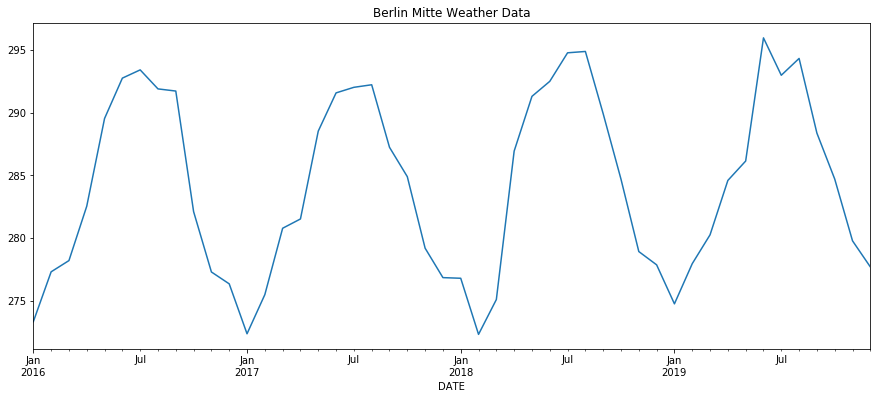

In [166]:
df2['TG'].plot(figsize=(15,6),title='Berlin Mitte Weather Data')

In [167]:
# ok now will try n do whatever i did for final project presentation

### Baseline Model - prediction based on previous month's weather

In [168]:
df2_previous = df2['TG'].to_frame().shift(1).rename(columns = {'TG': 'TG_previous'})

In [169]:
df2_current = df2['TG'].to_frame().rename(columns = {'TG' : 'TG_current'})

In [170]:
df2_baseline = pd.concat([df2_previous, df2_current], axis = 1)

In [171]:
df2_baseline.head() # gotta remove one row with NaNs

,TG_previous,TG_current
DATE,,
2016-01-01,NaN,273.340323
2016-02-01,273.340323,277.315517
2016-03-01,277.315517,278.211290
2016-04-01,278.211290,282.546667
2016-05-01,282.546667,289.540323


In [172]:
df2_baseline = df2_baseline[1:]

In [173]:
# now will compute RMSE to establish some sort of baseline

In [174]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

In [175]:
rmse_baseline = sqrt(MSE(df2_baseline.TG_previous, df2_baseline.TG_current))
rmse_baseline

4.38953472610706

### SARIMA model is specified (𝑝,𝑑,𝑞)×(𝑃,𝐷,𝑄)𝑠
### i.e. order & seasonal order

In [176]:
import itertools

In [177]:
# order of autoregressive component, no. of lags to be used as predictors
p = [0, 1, 2, 3]

In [178]:
# min no. of steps req for differencing trend
d = [0, 1]

In [179]:
# order of moving average term, 
q = [0, 1, 2, 3]

In [180]:
pdq_list = list(itertools.product(p, d, q))

In [181]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq_list]

In [182]:
seasonal_pdq # cool looks nice!

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 0, 3, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 1, 3, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 0, 3, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 0, 2, 12),
 (3, 0, 3, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12),
 (3, 1, 2, 12),
 (3, 1, 3, 12)]

In [183]:
# now for grid search

In [184]:
import statsmodels.api as sm

In [53]:
import warnings
warnings.filterwarnings('ignore')

for param in pdq_list:
    for seasonal_param in seasonal_pdq:
        m = sm.tsa.statespace.SARIMAX(df2.TG, order = param, seasonal_order = seasonal_param, 
                                 enforce_stationarity = False, enforce_invertibility = False)
        m.initialize()
        results = m.fit()
        print('SARIMA{}*{}12 - AIC{}:'.format(param, seasonal_param, results.aic))

SARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC666.5641678459419:
SARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC1288.0998438492627:
SARIMA(0, 0, 0)*(0, 0, 2, 12)12 - AIC310.6177695213692:
SARIMA(0, 0, 0)*(0, 0, 3, 12)12 - AIC161.18168338467245:
SARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC174.48703222450058:
SARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC108.61718617350972:
SARIMA(0, 0, 0)*(0, 1, 2, 12)12 - AIC52.684590156527456:
SARIMA(0, 0, 0)*(0, 1, 3, 12)12 - AIC8.0:
SARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC180.13271730274295:
SARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC163.40395706451346:
SARIMA(0, 0, 0)*(1, 0, 2, 12)12 - AIC112.36949897720243:
SARIMA(0, 0, 0)*(1, 0, 3, 12)12 - AIC66.37667861137822:
SARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC114.18637306188614:
SARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC109.78980617702365:
SARIMA(0, 0, 0)*(1, 1, 2, 12)12 - AIC53.90710285882351:
SARIMA(0, 0, 0)*(1, 1, 3, 12)12 - AIC10.0:
SARIMA(0, 0, 0)*(2, 0, 0, 12)12 - AIC112.29246361637729:
SARIMA(0, 0, 0)*(2, 0, 1, 12)12 - AIC112.84225138563019:
SARIMA(

SARIMA(0, 1, 0)*(3, 0, 2, 12)12 - AIC67.43929600561748:
SARIMA(0, 1, 0)*(3, 0, 3, 12)12 - AIC65.01066773709337:
SARIMA(0, 1, 0)*(3, 1, 0, 12)12 - AIC8.0:
SARIMA(0, 1, 0)*(3, 1, 1, 12)12 - AIC10.0:
SARIMA(0, 1, 0)*(3, 1, 2, 12)12 - AIC12.0:
SARIMA(0, 1, 0)*(3, 1, 3, 12)12 - AIC14.0:
SARIMA(0, 1, 1)*(0, 0, 0, 12)12 - AIC260.07167940888326:
SARIMA(0, 1, 1)*(0, 0, 1, 12)12 - AIC1296.2061968307023:
SARIMA(0, 1, 1)*(0, 0, 2, 12)12 - AIC127.95863931484527:
SARIMA(0, 1, 1)*(0, 0, 3, 12)12 - AIC63.531536474755185:
SARIMA(0, 1, 1)*(0, 1, 0, 12)12 - AIC169.46320436394745:
SARIMA(0, 1, 1)*(0, 1, 1, 12)12 - AIC98.17553085501706:
SARIMA(0, 1, 1)*(0, 1, 2, 12)12 - AIC46.071714866398786:
SARIMA(0, 1, 1)*(0, 1, 3, 12)12 - AIC10.0:
SARIMA(0, 1, 1)*(1, 0, 0, 12)12 - AIC179.59199757986812:
SARIMA(0, 1, 1)*(1, 0, 1, 12)12 - AIC1277.9938796768138:
SARIMA(0, 1, 1)*(1, 0, 2, 12)12 - AIC109.78915294662391:
SARIMA(0, 1, 1)*(1, 0, 3, 12)12 - AIC56.97300657844196:
SARIMA(0, 1, 1)*(1, 1, 0, 12)12 - AIC112.03221052

SARIMA(1, 0, 1)*(2, 1, 1, 12)12 - AIC56.64558558826828:
SARIMA(1, 0, 1)*(2, 1, 2, 12)12 - AIC52.27870503362966:
SARIMA(1, 0, 1)*(2, 1, 3, 12)12 - AIC16.0:
SARIMA(1, 0, 1)*(3, 0, 0, 12)12 - AIC41.947179829962714:
SARIMA(1, 0, 1)*(3, 0, 1, 12)12 - AIC44.414794568027474:
SARIMA(1, 0, 1)*(3, 0, 2, 12)12 - AIC47.33700619515186:
SARIMA(1, 0, 1)*(3, 0, 3, 12)12 - AIC48.03590960830189:
SARIMA(1, 0, 1)*(3, 1, 0, 12)12 - AIC12.0:
SARIMA(1, 0, 1)*(3, 1, 1, 12)12 - AIC14.0:
SARIMA(1, 0, 1)*(3, 1, 2, 12)12 - AIC16.0:
SARIMA(1, 0, 1)*(3, 1, 3, 12)12 - AIC18.0:
SARIMA(1, 0, 2)*(0, 0, 0, 12)12 - AIC260.83817856008034:
SARIMA(1, 0, 2)*(0, 0, 1, 12)12 - AIC1313.7974880592387:
SARIMA(1, 0, 2)*(0, 0, 2, 12)12 - AIC130.50988177802196:
SARIMA(1, 0, 2)*(0, 0, 3, 12)12 - AIC62.76557613446527:
SARIMA(1, 0, 2)*(0, 1, 0, 12)12 - AIC168.47486402156284:
SARIMA(1, 0, 2)*(0, 1, 1, 12)12 - AIC100.05972280900865:
SARIMA(1, 0, 2)*(0, 1, 2, 12)12 - AIC41.894379826875415:
SARIMA(1, 0, 2)*(0, 1, 3, 12)12 - AIC14.0:
SARIMA

SARIMA(1, 1, 2)*(2, 0, 0, 12)12 - AIC105.6101560728848:
SARIMA(1, 1, 2)*(2, 0, 1, 12)12 - AIC838.1740156333094:
SARIMA(1, 1, 2)*(2, 0, 2, 12)12 - AIC82.97673869964453:
SARIMA(1, 1, 2)*(2, 0, 3, 12)12 - AIC38.409011745135054:
SARIMA(1, 1, 2)*(2, 1, 0, 12)12 - AIC44.08345686438188:
SARIMA(1, 1, 2)*(2, 1, 1, 12)12 - AIC45.75894841915506:
SARIMA(1, 1, 2)*(2, 1, 2, 12)12 - AIC41.51008916422342:
SARIMA(1, 1, 2)*(2, 1, 3, 12)12 - AIC18.0:
SARIMA(1, 1, 2)*(3, 0, 0, 12)12 - AIC45.26042596424308:
SARIMA(1, 1, 2)*(3, 0, 1, 12)12 - AIC47.26043292196502:
SARIMA(1, 1, 2)*(3, 0, 2, 12)12 - AIC52.49929584884294:
SARIMA(1, 1, 2)*(3, 0, 3, 12)12 - AIC39.21797781159975:
SARIMA(1, 1, 2)*(3, 1, 0, 12)12 - AIC14.0:
SARIMA(1, 1, 2)*(3, 1, 1, 12)12 - AIC16.0:
SARIMA(1, 1, 2)*(3, 1, 2, 12)12 - AIC18.0:
SARIMA(1, 1, 2)*(3, 1, 3, 12)12 - AIC20.0:
SARIMA(1, 1, 3)*(0, 0, 0, 12)12 - AIC247.41415745222994:
SARIMA(1, 1, 3)*(0, 0, 1, 12)12 - AIC2169.13074706157:
SARIMA(1, 1, 3)*(0, 0, 2, 12)12 - AIC111.10137655449576:

SARIMA(2, 0, 3)*(1, 0, 2, 12)12 - AIC110.25395777702805:
SARIMA(2, 0, 3)*(1, 0, 3, 12)12 - AIC62.08815313847149:
SARIMA(2, 0, 3)*(1, 1, 0, 12)12 - AIC103.3220170909196:
SARIMA(2, 0, 3)*(1, 1, 1, 12)12 - AIC87.0618113742012:
SARIMA(2, 0, 3)*(1, 1, 2, 12)12 - AIC8.701777537696117:
SARIMA(2, 0, 3)*(1, 1, 3, 12)12 - AIC20.0:
SARIMA(2, 0, 3)*(2, 0, 0, 12)12 - AIC95.8576445295855:
SARIMA(2, 0, 3)*(2, 0, 1, 12)12 - AIC98.11543514110491:
SARIMA(2, 0, 3)*(2, 0, 2, 12)12 - AIC81.65342290774835:
SARIMA(2, 0, 3)*(2, 0, 3, 12)12 - AIC45.45443377881348:
SARIMA(2, 0, 3)*(2, 1, 0, 12)12 - AIC46.10494264675168:
SARIMA(2, 0, 3)*(2, 1, 1, 12)12 - AIC49.95875105273738:
SARIMA(2, 0, 3)*(2, 1, 2, 12)12 - AIC11.234224805300801:
SARIMA(2, 0, 3)*(2, 1, 3, 12)12 - AIC22.0:
SARIMA(2, 0, 3)*(3, 0, 0, 12)12 - AIC50.308641614767744:
SARIMA(2, 0, 3)*(3, 0, 1, 12)12 - AIC53.915408857590315:
SARIMA(2, 0, 3)*(3, 0, 2, 12)12 - AIC56.16491235128141:
SARIMA(2, 0, 3)*(3, 0, 3, 12)12 - AIC46.456118553889425:
SARIMA(2, 0, 3)

SARIMA(3, 0, 0)*(0, 1, 1, 12)12 - AIC113.97544435603523:
SARIMA(3, 0, 0)*(0, 1, 2, 12)12 - AIC56.55849684012077:
SARIMA(3, 0, 0)*(0, 1, 3, 12)12 - AIC14.0:
SARIMA(3, 0, 0)*(1, 0, 0, 12)12 - AIC177.9876804972968:
SARIMA(3, 0, 0)*(1, 0, 1, 12)12 - AIC158.54619489197754:
SARIMA(3, 0, 0)*(1, 0, 2, 12)12 - AIC120.75041411389861:
SARIMA(3, 0, 0)*(1, 0, 3, 12)12 - AIC72.65248329473675:
SARIMA(3, 0, 0)*(1, 1, 0, 12)12 - AIC98.47153472300623:
SARIMA(3, 0, 0)*(1, 1, 1, 12)12 - AIC99.41386029762121:
SARIMA(3, 0, 0)*(1, 1, 2, 12)12 - AIC51.65980398966584:
SARIMA(3, 0, 0)*(1, 1, 3, 12)12 - AIC16.0:
SARIMA(3, 0, 0)*(2, 0, 0, 12)12 - AIC80.58175135367713:
SARIMA(3, 0, 0)*(2, 0, 1, 12)12 - AIC80.99831200147703:
SARIMA(3, 0, 0)*(2, 0, 2, 12)12 - AIC82.32599838698371:
SARIMA(3, 0, 0)*(2, 0, 3, 12)12 - AIC55.961251792268826:
SARIMA(3, 0, 0)*(2, 1, 0, 12)12 - AIC43.193424074772935:
SARIMA(3, 0, 0)*(2, 1, 1, 12)12 - AIC44.83240088569124:
SARIMA(3, 0, 0)*(2, 1, 2, 12)12 - AIC46.789058258499054:
SARIMA(3, 0,

SARIMA(3, 1, 1)*(0, 0, 1, 12)12 - AIC1401.7403984756727:
SARIMA(3, 1, 1)*(0, 0, 2, 12)12 - AIC124.6566499840172:
SARIMA(3, 1, 1)*(0, 0, 3, 12)12 - AIC59.42307081032893:
SARIMA(3, 1, 1)*(0, 1, 0, 12)12 - AIC167.94138717442559:
SARIMA(3, 1, 1)*(0, 1, 1, 12)12 - AIC98.90463905091433:
SARIMA(3, 1, 1)*(0, 1, 2, 12)12 - AIC48.48689034044423:
SARIMA(3, 1, 1)*(0, 1, 3, 12)12 - AIC16.0:
SARIMA(3, 1, 1)*(1, 0, 0, 12)12 - AIC168.22204103080406:
SARIMA(3, 1, 1)*(1, 0, 1, 12)12 - AIC1344.0486957637531:
SARIMA(3, 1, 1)*(1, 0, 2, 12)12 - AIC117.3339124478514:
SARIMA(3, 1, 1)*(1, 0, 3, 12)12 - AIC56.776204742285294:
SARIMA(3, 1, 1)*(1, 1, 0, 12)12 - AIC83.89295607168756:
SARIMA(3, 1, 1)*(1, 1, 1, 12)12 - AIC86.40106392684551:
SARIMA(3, 1, 1)*(1, 1, 2, 12)12 - AIC44.08307754190362:
SARIMA(3, 1, 1)*(1, 1, 3, 12)12 - AIC18.0:
SARIMA(3, 1, 1)*(2, 0, 0, 12)12 - AIC82.02599902801947:
SARIMA(3, 1, 1)*(2, 0, 1, 12)12 - AIC776.3842867937359:
SARIMA(3, 1, 1)*(2, 0, 2, 12)12 - AIC85.40268970510647:
SARIMA(3, 1, 

In [185]:
# cool this ran much faster - possibly coz of much lesser data to process

In [186]:
# lowerst combinations have aic value of 5.1: 3,1,3 * 3,0,3,12

### Train/Test split

In [187]:
# 1st iter (drop 2019)
y_train1 = df2['2016':'2018']
y_test1 = df2['2019']

### SARIMA model

In [189]:
m1 = sm.tsa.statespace.SARIMAX(y_train1.TG, order = (3, 1, 3), seasonal = (3, 0, 3, 12),
                             enforce_stationarity=False,
                            enforce_invertibility=False)
m1.initialize()
sarimax_results1 = m1.fit()

In [190]:
aic1 = sarimax_results1.aic
aic1

159.14070934653998

In [191]:
summary1 = sarimax_results1.summary()
summary1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     TG   No. Observations:                   36
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -72.570
Date:                Sun, 24 May 2020   AIC                            159.141
Time:                        16:30:09   BIC                            169.179
Sample:                    01-01-2016   HQIC                           162.413
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8847      0.274      3.229      0.001       0.348       1.422
ar.L2          0.4127      0.455      0.907      0.364      -0.479       1.305
ar.L3         -0.7837      0.252     -3.114      0.002      -1.277      -0.290
ma.L1         -0.9050   3.38e+04  -2.68e-05      1.000   -6.63e+04    6.63e+04
ma.L2         -0.9050   1.28e+04  -7.05e-05      1.000   -2.52e+04    2.52e+04
ma.L3          1.0000   3.59e+04   2.78e-05      1.000   -7.04e+04    7.04e+04
sigma2         4.9423   1.78e+05   2.78e-05      1.000   -3.48e+05    3.48e+05
===================================================================================
Ljung-Box (Q):                       36.16   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.20   Prob(JB):                         0.63
Heteroskedasticity (H):               1.16   Skew:                            -0.23
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

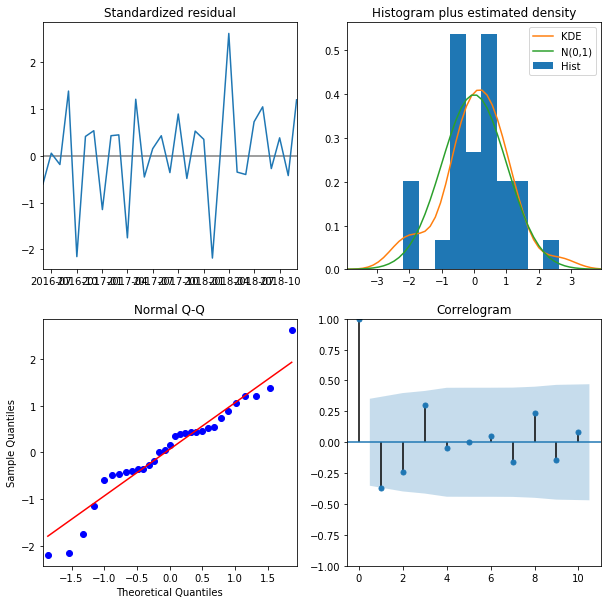

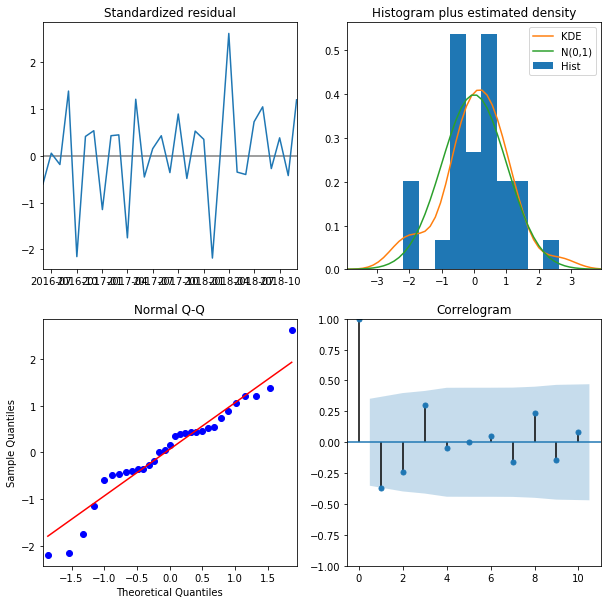

In [192]:
sarimax_results1.plot_diagnostics(figsize = (10, 10))

In [193]:
# ok aic with best params is somewhat higher...why?? - but still comparable to what andrey got
# 1. no obvious seasonality of residuals 
# 2. histogram of residuals are normally distributed with mean around zero
# 3. this also seen in q-q plot which shows fairly linear trend when residuals are normally distributed
# 4. autocorrel plot also shows low correl with lagged data

### Cross-validation

In [194]:
# 2nd iter (drop 2018)
start_remove = pd.to_datetime('2018-01-01')
end_remove = pd.to_datetime('2018-12-31')

In [195]:
y_test2 = df2['2018']
y_train2 = df2.loc[(df2.index < start_remove) | (df2.index > end_remove)]

In [196]:
m2 = sm.tsa.statespace.SARIMAX(y_train2.TG, order = (3, 1, 3), seasonal = (3, 0, 3, 12),
                             enforce_stationarity=False,
                            enforce_invertibility=False)
m2.initialize()
sarimax_results2 = m2.fit()

In [197]:
aic2 = sarimax_results2.aic
aic2

133.58994376651444

In [198]:
# 3rd iter drop 2017
start_remove = pd.to_datetime('2017-01-01')
end_remove = pd.to_datetime('2017-12-31')

In [199]:
y_test3 = df2['2017']
y_train3 = df2.loc[(df2.index < start_remove) | (df2.index > end_remove)]

In [200]:
m3 = sm.tsa.statespace.SARIMAX(y_train3.TG, order = (3, 1, 3), seasonal = (3, 0, 3, 12),
                             enforce_stationarity=False,
                            enforce_invertibility=False)
m3.initialize()
sarimax_results3 = m3.fit()

In [201]:
aic3 = sarimax_results1.aic
aic3

159.14070934653998

In [202]:
# 4th iter drop 2016
start_remove = pd.to_datetime('2016-01-01')
end_remove = pd.to_datetime('2016-12-31')

In [203]:
y_test4 = df2['2016']
y_train4 = df2.loc[(df2.index < start_remove) | (df2.index > end_remove)]

In [204]:
m4 = sm.tsa.statespace.SARIMAX(y_train4.TG, order = (3, 1, 3), seasonal = (3, 0, 3, 12),
                             enforce_stationarity=False,
                            enforce_invertibility=False)
m4.initialize()
sarimax_results4 = m4.fit()

In [205]:
aic4 = sarimax_results4.aic
aic4

148.28068354982915

In [206]:
print('Crossvalidation Results (AIC Scores):', aic1, aic2, aic3, aic4)

Crossvalidation Results (AIC Scores): 159.14070934653998 133.58994376651444 159.14070934653998 148.28068354982915


In [207]:
# cool - again all in the range that andrey got 

### Predictions 

In [208]:
predict1 = sarimax_results1.get_prediction(start = pd.to_datetime('2019-01-01'), end = pd.to_datetime('2019-12-01'), dynamic = True)

In [209]:
predict1_ci1 = predict1.conf_int()

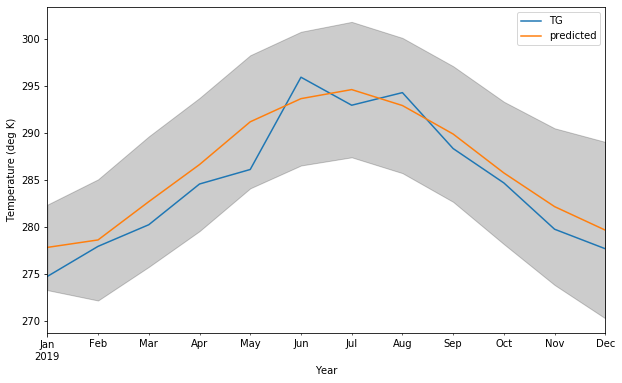

In [215]:
ax = y_test1.TG[:365].plot(figsize = (10,6))
predict1.predicted_mean.plot(ax = ax, label = 'predicted')
ax.fill_between(predict1_ci1.index, predict1_ci1.iloc[:,0], predict1_ci1.iloc[:,1], color = 'k', alpha = 0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (deg K)')
plt.legend()

In [216]:
y_predicted1 = predict1.predicted_mean

In [217]:
y_actual1 = y_test1.TG[0:365]

In [218]:
rmse1 = sqrt(MSE(y_predicted1, y_actual1))
rmse1

2.401101154340642

In [219]:
# for comparison: 
rmse_baseline

4.38953472610706

In [253]:
# okay this is much better! nice reduction in rmse & curves look better than before 
# no patience to write out loop for forecasting...will repeat Stefan style ARIMA with same data instead

### Using same monthly data to manually generate stationary data, run ARIMA model and make 
### out of sample forecasts (similar to what Stefan did in class with flights data)

### first without decomposing the data

Figure(864x432)


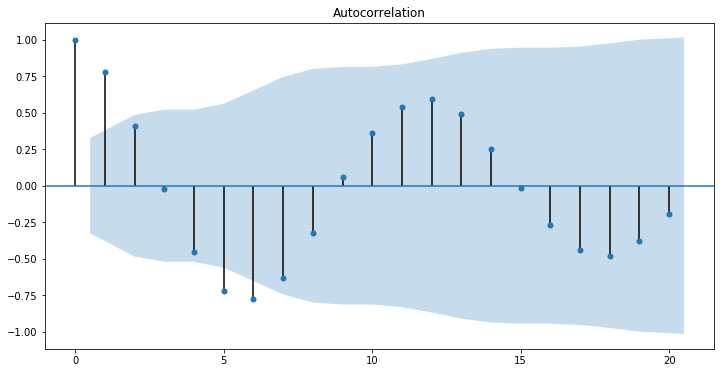

In [222]:
print(plot_acf(y_train1.TG, lags=20))

Figure(864x432)


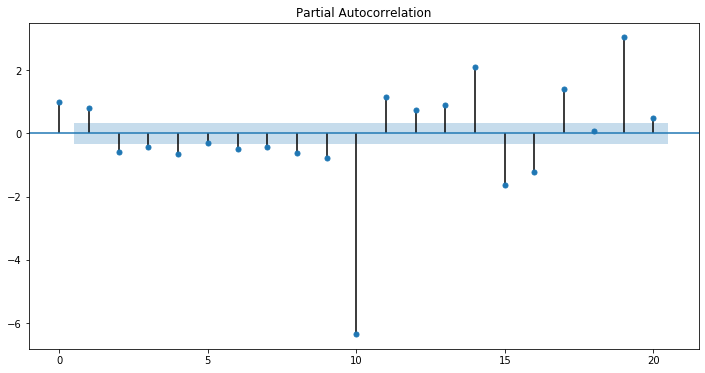

In [223]:
print(plot_pacf(y_train1.TG, lags=20))

In [231]:
# Fit the model
ar_weather = AutoReg(y_train1.TG, lags=2)
res_weather = ar_weather.fit()
print(res_weather.summary())

                            AutoReg Model Results                             
Dep. Variable:                     TG   No. Observations:                   36
Model:                     AutoReg(2)   Log Likelihood                 -87.896
Method:               Conditional MLE   S.D. of innovations              3.210
Date:                Sun, 24 May 2020   AIC                              2.568
Time:                        16:37:14   BIC                              2.747
Sample:                    03-01-2016   HQIC                             2.629
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.4115     22.926      3.726      0.000      40.478     130.345
TG.L1          1.3246      0.132     10.036      0.000       1.066       1.583
TG.L2         -0.6251      0.129     -4.863      0.0

In [232]:
parameters = res_weather.params

In [233]:
start_value = '2016'

In [234]:
## construct walk-forward forecast
parameters = res_weather.params

b = parameters[0]

# create an empty list of predictions
out_of_sample_nonstationary = []

# create a loop to predict the value for every timestep in y_test
for i in range(len(y_train1), len(y_train1)+len(y_test1)):
    out_of_sample_nonstationary.append(b + sum(df2[start_value:].TG[i-1:i].values * parameters[:0:-1].values))

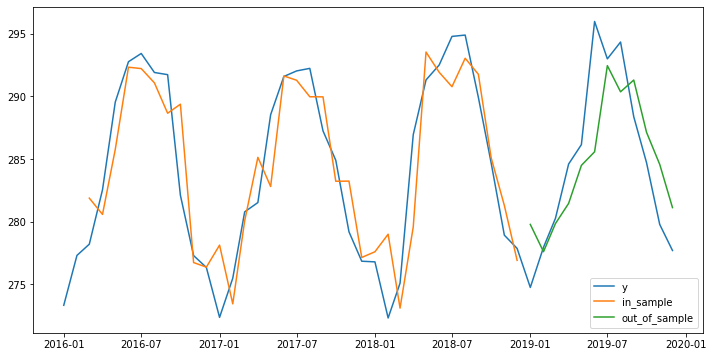

In [235]:
# Plot the three plots
plt.plot(df2.TG, label='y')
plt.plot(res_weather.predict(), label='in_sample')
plt.plot(y_test1.index, out_of_sample_nonstationary, label='out_of_sample')
plt.legend()

In [236]:
parameters[0]

85.41146626256284

In [237]:
in_sample_nonstationary = []

b = parameters[0]
w1 = parameters[1]
w2 = parameters[2]


for date in y_train1.index[2:]:
    last_month = date - pd.tseries.offsets.DateOffset(months=1)
    two_month_prior = date - pd.tseries.offsets.DateOffset(months=2)
    in_sample_nonstationary.append(b + w1 * y_train1.loc[last_month].TG + w2 * y_train1.loc[two_month_prior].TG)

### Repeating after decomposing data 

In [238]:
y_train1 = df2['2016':'2018']
y_test1 = df2['2019']

In [239]:
y_train1['log_TG'] = np.log(y_train1.TG)
y_train1['difference'] = y_train1.log_TG.diff()
y_train1['monthly_means'] = y_train1.groupby('month')['difference'].transform('mean')
y_train1['deseasonalized'] = y_train1.difference - y_train1.monthly_means
y_train1.head()

,TG,year,month,day,log_TG,difference,monthly_means,deseasonalized
DATE,,,,,,,,
2016-01-01,273.340323,2016,1,1,5.610718,NaN,-0.007348,NaN
2016-02-01,277.315517,2016,2,1,5.625156,0.014438,0.003179,0.011259
2016-03-01,278.211290,2016,3,1,5.628381,0.003225,0.010799,-0.007574
2016-04-01,282.546667,2016,4,1,5.643844,0.015463,0.020073,-0.004611
2016-05-01,289.540323,2016,5,1,5.668295,0.024451,0.021374,0.003077


### Decompose the test data

In [240]:
y_test1['monthly_means'] = y_train1['monthly_means'][:12].values
y_test1['log_TG'] = np.log(y_test1.TG)
y_test1['difference'] = y_test1.log_TG.diff()
y_test1['deseasonalized'] = y_test1.difference - y_test1.monthly_means
y_test1.head()

,TG,year,month,day,monthly_means,log_TG,difference,deseasonalized
DATE,,,,,,,,
2019-01-01,274.762903,2019,1,1,-0.007348,5.615909,NaN,NaN
2019-02-01,277.964286,2019,2,1,0.003179,5.627493,0.011584,0.008405
2019-03-01,280.266129,2019,3,1,0.010799,5.635740,0.008247,-0.002552
2019-04-01,284.600000,2019,4,1,0.020073,5.651085,0.015345,-0.004728
2019-05-01,286.146774,2019,5,1,0.021374,5.656505,0.005420,-0.015954


### Look at the Autocorrelation and Partial Autocorrelation of the decomposed time series

In [241]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Figure(864x432)


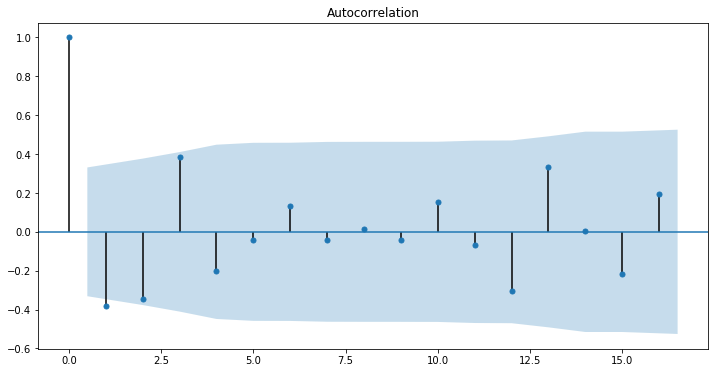

In [242]:
print(plot_acf(y_train1.deseasonalized[1:]))

Figure(864x432)


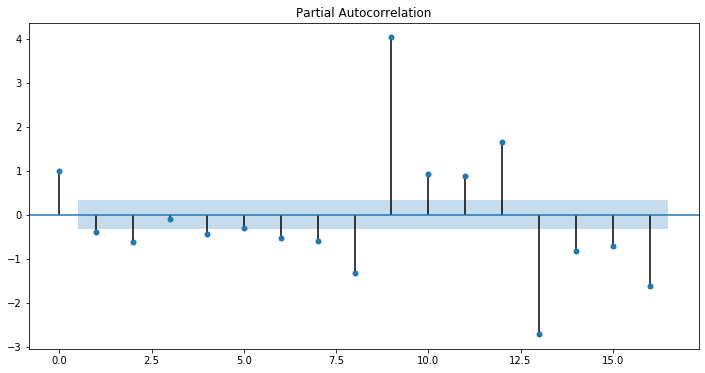

In [243]:
print(plot_pacf(y_train1.deseasonalized[1:]))

### Fit the model

In [244]:
from statsmodels.tsa.ar_model import AutoReg

In [245]:
dec_ar = AutoReg(y_train1.deseasonalized[1:], 1)
dec_res = dec_ar.fit()
print(dec_res.summary())

                            AutoReg Model Results                             
Dep. Variable:         deseasonalized   No. Observations:                   35
Model:                     AutoReg(1)   Log Likelihood                 119.030
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Sun, 24 May 2020   AIC                             -9.663
Time:                        16:39:41   BIC                             -9.528
Sample:                    03-01-2016   HQIC                            -9.617
                         - 12-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -0.0003      0.001     -0.277      0.782      -0.003       0.002
deseasonalized.L1    -0.3830      0.153     -2.501      0.012      -0.683      -0.083
                        

In [246]:
parameters = dec_res.params.values

In [247]:
parameters

array([-3.47153900e-04, -3.82959708e-01])

In [248]:
in_sample_stationary = []

b = dec_res.params[0]
w1 = dec_res.params[1]

for date in y_train1.index[2:]:
    last_month = date - pd.tseries.offsets.DateOffset(months=1)
    # Add predict the next value, add back the monthly mean and the previous observation and revert the log-transformation
    in_sample_stationary.append(np.exp(b + w1 * y_train1.loc[last_month].deseasonalized + y_train1.loc[date].monthly_means + y_train1.loc[last_month].log_TG))


#for date in y_train_flights.index[2:]:
#    pred_test.append(np.exp(np.cumsum(dec_res.predict(start=date, end=date) + y_train_flights.loc[date].monthly_means) + y_train_flights['log_passengers'][date])[date])

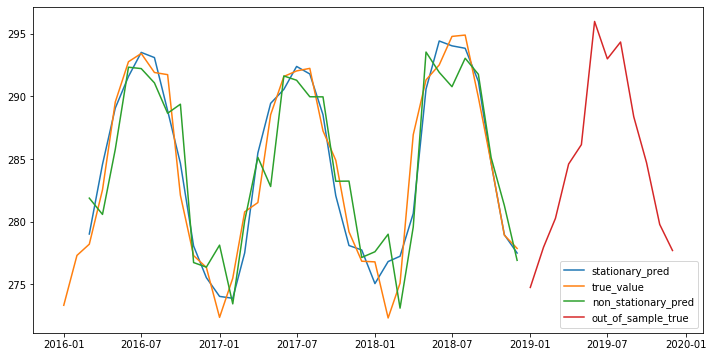

In [249]:
# Plot everything together
# plt.plot(y_train_flights.reconstruct, label='stationary_pred')
plt.plot(y_train1.index[2:], in_sample_stationary, label='stationary_pred')
plt.plot(y_train1.TG, label='true_value')
# plt.plot(res_flights.predict(), label='non-stationary')
plt.plot(y_train1.index[2:], in_sample_nonstationary, label='non_stationary_pred')
plt.plot(y_test1.TG, label='out_of_sample_true')
# plt.plot(y_test_flights.index, out_of_sample, label='out_of_sample_stationary')
# plt.plot(y_test_flights.index, predictions, label='out_of_sample_non_stationary')
plt.legend()

In [250]:
from sklearn.metrics import mean_squared_error

# Compare the mean_squared_error of the two approaches
print(f'Stationarized time series: {mean_squared_error(y_train1.TG[2:], in_sample_stationary)}')
print(f'Non-Stationarized time series: {mean_squared_error(y_train1.TG[2:], in_sample_nonstationary)}')

Stationarized time series: 4.242940535082973
Non-Stationarized time series: 10.30323404536124


At least in sample the stationarized time series performs a lot better. But of course we are rather interested on the performance on the test data set.

### Make Out-Of-Sample Forecast

In [251]:
out_of_sample_stationary = []

for i, date in enumerate(y_test1.index):
    last_month = date - pd.tseries.offsets.DateOffset(months=1)
    if i == 0:
        out_of_sample_stationary.append(np.exp(dec_res.params[0] + dec_res.params[1] * y_train1.loc[last_month].deseasonalized + y_test1.loc[date].monthly_means + y_train1.loc[last_month].log_TG))
    else:
        out_of_sample_stationary.append(np.exp(dec_res.params[0] + dec_res.params[1] * y_test1.loc[last_month].deseasonalized + y_test1.loc[date].monthly_means + y_test1.loc[last_month].log_TG))

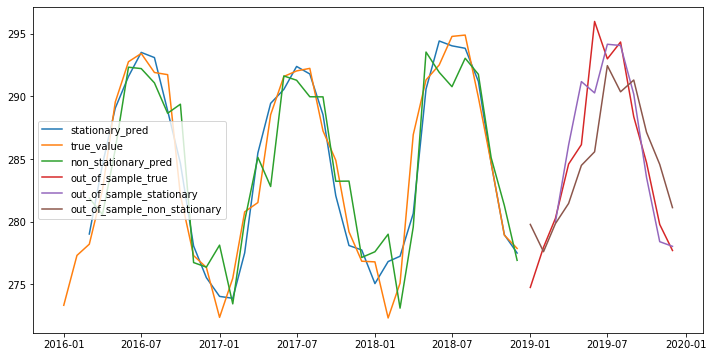

In [252]:
# Plot everything together
# plt.plot(y_train_flights.reconstruct, label='stationary_pred')
plt.plot(y_train1.index[2:], in_sample_stationary, label='stationary_pred')
plt.plot(y_train1.TG, label='true_value')
# plt.plot(res_flights.predict(), label='non-stationary')
plt.plot(y_train1.index[2:], in_sample_nonstationary, label='non_stationary_pred')
plt.plot(y_test1.TG, label='out_of_sample_true')
plt.plot(y_test1.index, out_of_sample_stationary, label='out_of_sample_stationary')
plt.plot(y_test1.index, out_of_sample_nonstationary, label='out_of_sample_non_stationary')
plt.legend()

In [ ]:
# ok this does not look bad either...